# Optimal Gradient Method Example


This code tests Optimized Gradient Method (OGM) which is the exact optimal method
that reduces function value respect to initial distance to solution for L-smooth
convex functions. Introduced in "Optimized first-order methods for smooth convex
minimization" by Donghwan Kim, Jeffrey A Fessler (2016).

## Import the required libraries

In [ ]:
import pepflow as pf
import numpy as np
import sympy as sp
import matplotlib.pyplot as plt
import itertools
import functools
from IPython.display import display

## Define the functions

In [2]:
L = pf.Parameter("L")
f = pf.SmoothConvexFunction(is_basis=True, tags=["f"], L=L)

## Write a function to return the PEPContext associated with OGM

In [3]:
@functools.cache
def theta(i, N):
    if i == -1:
        return 0
    if i == N:
        return 1 / sp.S(2) * (sp.S(1) + sp.sqrt(8 * theta(N - 1, N) ** 2 + sp.S(1)))
    return 1 / sp.S(2) * (sp.S(1) + sp.sqrt(4 * theta(i - 1, N) ** 2 + sp.S(1)))

In [4]:
def make_ctx_ogm(
    ctx_name: str, N: int | sp.Integer, stepsize: pf.Parameter
) -> pf.PEPContext:
    ctx_ogm = pf.PEPContext(ctx_name).set_as_current()
    x = pf.Vector(is_basis=True, tags=["x_0"])
    z = x
    f.set_stationary_point("x_star")
    for i in range(N):
        y = x - stepsize * f.grad(x)
        z = z - 2 * stepsize * theta(i, N) * f.grad(x)
        z.add_tag(f"z_{i + 1}")
        x = (1 - 1 / theta(i + 1, N)) * y + 1 / theta(i + 1, N) * z
        x.add_tag(f"x_{i + 1}")
    return ctx_ogm

## Numerical evidence of convergence of OGM

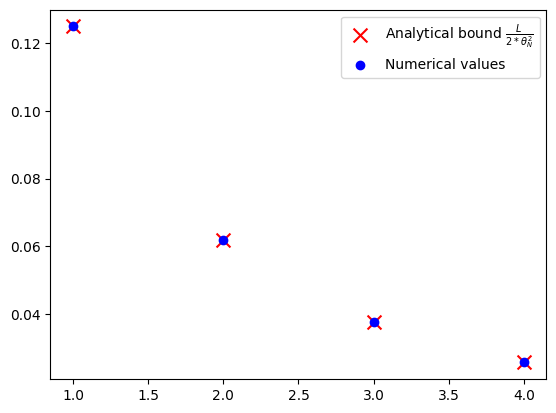

In [5]:
N = 5
R = pf.Parameter("R")
L_value = 1
R_value = 1

opt_values = []
for k in range(1, N):
    ctx_plt = make_ctx_ogm(ctx_name=f"ctx_plt_{k}", N=k, stepsize=1 / L)
    pb_plt = pf.PEPBuilder(ctx_plt)
    pb_plt.add_initial_constraint(
        ((ctx_plt["x_0"] - ctx_plt["x_star"]) ** 2).le(R, name="initial_condition")
    )
    x_k = ctx_plt[f"x_{k}"]
    pb_plt.set_performance_metric(f(x_k) - f(ctx_plt["x_star"]))
    result = pb_plt.solve(resolve_parameters={"L": L_value, "R": R_value})
    opt_values.append(result.opt_value)

iters = np.arange(1, N)
analytical_values = [L_value / (2 * theta(i, i) ** 2) for i in iters]
plt.scatter(
    iters,
    analytical_values,
    color="red",
    marker="x",
    s=100,
    label="Analytical bound $\\frac{L}{2*\\theta_N^2}$",
)
plt.scatter(iters, opt_values, color="blue", marker="o", label="Numerical values")
plt.legend()

## Verification of convergence of OGM

In [6]:
N = 2

ctx_prf = make_ctx_ogm(ctx_name="ctx_prf", N=N, stepsize=1 / L)
pb_prf = pf.PEPBuilder(ctx_prf)
pb_prf.add_initial_constraint(
    ((ctx_prf["x_0"] - ctx_prf["x_star"]) ** 2).le(R, name="initial_condition")
)
pb_prf.set_performance_metric(f(ctx_prf[f"x_{N}"]) - f(ctx_prf["x_star"]))

result = pb_prf.solve(resolve_parameters={"L": L_value, "R": R_value})
print(result.opt_value)

# Dual variables associated with the interpolations conditions of f with no relaxation
lamb_dense = result.get_scalar_constraint_dual_value_in_numpy(f)

0.06189185276165096


In [7]:
pf.launch_primal_interactive(
    pb_prf, ctx_prf, resolve_parameters={"L": L_value, "R": R_value}
)

Dash app running on http://127.0.0.1:8050/


- It turns out for OGM no further relaxation is needed. Now we store the results.


In [8]:
# Dual variable associated with the initial condition
tau_sol = result.dual_var_manager.dual_value("initial_condition")
# Dual variable associated with the interpolations conditions of f
lamb_sol = result.get_scalar_constraint_dual_value_in_numpy(f)
# Dual variable associated with the Gram matrix G
S_sol = result.get_gram_dual_matrix()

### Verify closed form expression of $\lambda$

In [9]:
def tag_to_index(tag, N=N):
    """This is a function that takes in a tag of an iterate and returns its index.
    We index "x_star" as "N+1 where N is the last iterate.
    """
    # Split the string on "_" and get the index
    if (idx := tag.split("_")[1]).isdigit():
        return int(idx)
    elif idx == "star":
        return N + 1

- Print the values of $\lambda$ obtained from the solver

In [10]:
lamb_sol.pprint()

<IPython.core.display.Math object>

- Consider proper candidate of closed form expression of $\lambda$

In [11]:
def lamb(tag_i, tag_j, N=N):
    i = tag_to_index(tag_i)
    j = tag_to_index(tag_j)
    if i == N + 1:  # Additional constraint 1 (between x_★)
        if j == 0:
            return lamb("x_0", "x_1")
        elif j < N:
            return lamb(f"x_{j}", f"x_{j + 1}") - lamb(f"x_{j - 1}", f"x_{j}")
        elif j == N:
            return 1 - lamb(f"x_{N - 1}", f"x_{N}")
    if i < N and i + 1 == j:  # Additional constraint 2 (consecutive)
        return 2 * theta(i, N) ** 2 / theta(N, N) ** 2
    return 0


lamb_cand = pf.pprint_labeled_matrix(
    lamb, lamb_sol.row_names, lamb_sol.col_names, return_matrix=True
)

<IPython.core.display.Math object>

- Check whether our candidate of $\lambda$ matches with solution

In [12]:
print(
    "Did we guess the right closed form of lambda?",
    np.allclose(lamb_cand, lamb_sol.matrix, atol=1e-3),
)

Did we guess the right closed form of lambda? True


### Closed form expression of $S$

- Create an ExpressionManager to translate $x_i$, $f(x_i)$, and $\nabla f(x_i)$ into a basis representation

In [13]:
pm = pf.ExpressionManager(ctx_prf, resolve_parameters={"L": L_value, "R": R_value})

In [14]:
S_sol.pprint()

<IPython.core.display.Math object>

In [15]:
x_N = ctx_prf[f"x_{N}"]
x_star = ctx_prf["x_star"]
z_N = ctx_prf[f"z_{N}"]
S_guess = (
    L / theta(N, N) ** 2 * 1 / 2 * (z_N - theta(N, N) / L * f.grad(x_N) - x_star) ** 2
)

S_guess_eval = pm.eval_scalar(S_guess).matrix
pf.pprint_labeled_matrix(S_guess_eval, S_sol.row_names, S_sol.col_names)

<IPython.core.display.Math object>

In [16]:
print(
    "Did we guess the right closed form of S?",
    np.allclose(S_guess_eval, S_sol.matrix, atol=1e-3),
)

Did we guess the right closed form of S? True


- Interestestingly, optimal method tends to have small rank of $S$

In [17]:
rank = np.linalg.matrix_rank(S_sol.matrix)
print(rank)

1


### Symbolic calculation

- Assemble the RHS of the proof.

In [18]:
interp_scalar_sum = pf.Scalar.zero()
for x_i, x_j in itertools.product(ctx_prf.tracked_point(f), ctx_prf.tracked_point(f)):
    if lamb(x_i.tag, x_j.tag) != 0:
        interp_scalar_sum += lamb(x_i.tag, x_j.tag) * f.interp_ineq(x_i.tag, x_j.tag)

display(interp_scalar_sum)

0+2/(1/2 + sqrt(1 + 8*(1/2 + sqrt(5)/2)**2)/2)**2*(f(x_1)-f(x_0)+grad_f(x_1)*(x_0-(x_1))+1/2*L*|grad_f(x_0)-grad_f(x_1)|^2)+2*(1/2 + sqrt(5)/2)**2/(1/2 + sqrt(1 + 8*(1/2 + sqrt(5)/2)**2)/2)**2*(f(x_2)-f(x_1)+grad_f(x_2)*(x_1-(x_2))+1/2*L*|grad_f(x_1)-grad_f(x_2)|^2)+2/(1/2 + sqrt(1 + 8*(1/2 + sqrt(5)/2)**2)/2)**2*(f(x_0)-f(x_star)+grad_f(x_0)*(x_star-x_0)+1/2*L*|grad_f(x_star)-grad_f(x_0)|^2)+-2/(1/2 + sqrt(1 + 8*(1/2 + sqrt(5)/2)**2)/2)**2 + 2*(1/2 + sqrt(5)/2)**2/(1/2 + sqrt(1 + 8*(1/2 + sqrt(5)/2)**2)/2)**2*(f(x_1)-f(x_star)+grad_f(x_1)*(x_star-(x_1))+1/2*L*|grad_f(x_star)-grad_f(x_1)|^2)+-2*(1/2 + sqrt(5)/2)**2/(1/2 + sqrt(1 + 8*(1/2 + sqrt(5)/2)**2)/2)**2 + 1*(f(x_2)-f(x_star)+grad_f(x_2)*(x_star-(x_2))+1/2*L*|grad_f(x_star)-grad_f(x_2)|^2)

In [19]:
RHS = interp_scalar_sum - S_guess
display(RHS)

0+2/(1/2 + sqrt(1 + 8*(1/2 + sqrt(5)/2)**2)/2)**2*(f(x_1)-f(x_0)+grad_f(x_1)*(x_0-(x_1))+1/2*L*|grad_f(x_0)-grad_f(x_1)|^2)+2*(1/2 + sqrt(5)/2)**2/(1/2 + sqrt(1 + 8*(1/2 + sqrt(5)/2)**2)/2)**2*(f(x_2)-f(x_1)+grad_f(x_2)*(x_1-(x_2))+1/2*L*|grad_f(x_1)-grad_f(x_2)|^2)+2/(1/2 + sqrt(1 + 8*(1/2 + sqrt(5)/2)**2)/2)**2*(f(x_0)-f(x_star)+grad_f(x_0)*(x_star-x_0)+1/2*L*|grad_f(x_star)-grad_f(x_0)|^2)+-2/(1/2 + sqrt(1 + 8*(1/2 + sqrt(5)/2)**2)/2)**2 + 2*(1/2 + sqrt(5)/2)**2/(1/2 + sqrt(1 + 8*(1/2 + sqrt(5)/2)**2)/2)**2*(f(x_1)-f(x_star)+grad_f(x_1)*(x_star-(x_1))+1/2*L*|grad_f(x_star)-grad_f(x_1)|^2)+-2*(1/2 + sqrt(5)/2)**2/(1/2 + sqrt(1 + 8*(1/2 + sqrt(5)/2)**2)/2)**2 + 1*(f(x_2)-f(x_star)+grad_f(x_2)*(x_star-(x_2))+1/2*L*|grad_f(x_star)-grad_f(x_2)|^2)-L/(1/2 + sqrt(1 + 8*(1/2 + sqrt(5)/2)**2)/2)**2*1/2*|z_2-(1/2 + sqrt(1 + 8*(1/2 + sqrt(5)/2)**2)/2)/L*grad_f(x_2)-x_star|^2

- Assemble the LHS of the proof

In [20]:
x_0 = ctx_prf["x_0"]
LHS = f(x_N) - f(x_star) - L / (2 * theta(N, N) ** 2) * (x_0 - x_star) ** 2
display(LHS)

f(x_2)-f(x_star)-L/2*(1/2 + sqrt(1 + 8*(1/2 + sqrt(5)/2)**2)/2)**2*|x_0-x_star|^2

In [21]:
diff = LHS - RHS
display(diff)

f(x_2)-f(x_star)-L/2*(1/2 + sqrt(1 + 8*(1/2 + sqrt(5)/2)**2)/2)**2*|x_0-x_star|^2-(0+2/(1/2 + sqrt(1 + 8*(1/2 + sqrt(5)/2)**2)/2)**2*(f(x_1)-f(x_0)+grad_f(x_1)*(x_0-(x_1))+1/2*L*|grad_f(x_0)-grad_f(x_1)|^2)+2*(1/2 + sqrt(5)/2)**2/(1/2 + sqrt(1 + 8*(1/2 + sqrt(5)/2)**2)/2)**2*(f(x_2)-f(x_1)+grad_f(x_2)*(x_1-(x_2))+1/2*L*|grad_f(x_1)-grad_f(x_2)|^2)+2/(1/2 + sqrt(1 + 8*(1/2 + sqrt(5)/2)**2)/2)**2*(f(x_0)-f(x_star)+grad_f(x_0)*(x_star-x_0)+1/2*L*|grad_f(x_star)-grad_f(x_0)|^2)+-2/(1/2 + sqrt(1 + 8*(1/2 + sqrt(5)/2)**2)/2)**2 + 2*(1/2 + sqrt(5)/2)**2/(1/2 + sqrt(1 + 8*(1/2 + sqrt(5)/2)**2)/2)**2*(f(x_1)-f(x_star)+grad_f(x_1)*(x_star-(x_1))+1/2*L*|grad_f(x_star)-grad_f(x_1)|^2)+-2*(1/2 + sqrt(5)/2)**2/(1/2 + sqrt(1 + 8*(1/2 + sqrt(5)/2)**2)/2)**2 + 1*(f(x_2)-f(x_star)+grad_f(x_2)*(x_star-(x_2))+1/2*L*|grad_f(x_star)-grad_f(x_2)|^2)-L/(1/2 + sqrt(1 + 8*(1/2 + sqrt(5)/2)**2)/2)**2*1/2*|z_2-(1/2 + sqrt(1 + 8*(1/2 + sqrt(5)/2)**2)/2)/L*grad_f(x_2)-x_star|^2)

In [22]:
pf.pprint_str(
    diff.repr_by_basis(ctx_prf, sympy_mode=True, resolve_parameters={"L": sp.S("L")})
)

<IPython.core.display.Math object>